In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from chessutils import find_coeffs
from boardgen import chessboard

In [3]:
from clusterization import clusterize

In [4]:
def intersect(i1, i2):
    return (i2[0] <= i1[1]) and (i1[0] <= i2[1])
def closeintervals(i1, i2):
    return intersect(i1, i2) and (abs(i1[2]-i2[2]) == 1)

def centerofmass(c):
    xm = 0
    ym = 0
    nm = 0
    for i in c:
        ns = i[1]-i[0]+1
        xm += 0.5*(i[1]+i[0])*ns
        ym += i[2]*ns
        nm += ns
    return xm/nm, ym/nm

In [5]:
PATH_TO_IMG = 'img'

In [7]:
IMGSIZE = 480
MAXSHEAR = 0.15
MINSCALE = 0.5
NC = 5

HFIMGSIZE = IMGSIZE // 2

In [8]:
figimgs = [f for f in os.listdir(PATH_TO_IMG) if f.split('_')[0]=='Chess']
figuresimgs = dict()
for f in figimgs:
    fn = f.split('_')[1].split('4')[0]
    img = cv2.imread(os.path.join(PATH_TO_IMG, f))
    figuresimgs[fn] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

figs = ['p', 'b', 'n', 'r', 'q', 'k']
colors = ['d', 'l']

In [9]:
parameters = {
    'numcell':8,
    'cellsize':45,
    'figures':figs,
    'colors':colors,
    'shear':MAXSHEAR,
    'scale':MINSCALE,
}

In [10]:
def randomboardpoints(nc, params):
    boardsize = params['cellsize'] * params['numcell']
    mask = 255*np.ones((boardsize,boardsize), np.uint8)
    nb = params['numcell']*params['numcell']
    npt = np.random.randint(1,nc+1,size=nb)
    for i in range(nb):
        xp = i % params['numcell']
        yp = i // params['numcell']
        sz = npt[i]
        if (xp != 0) and (yp != 0):
            mask[yp*params['cellsize']-sz:yp*params['cellsize']+sz,xp*params['cellsize']-sz:xp*params['cellsize']+sz] = 0
    return mask

In [11]:
def boardmask(imgsize):
    boardimage, _, vecs = chessboard(figuresimgs, np.random.rand(13), imgsize, parameters)
    blank_mask = randomboardpoints(NC, parameters)

    img = Image.fromarray(blank_mask, 'L')
    coeffs = find_coeffs(
         vecs.reshape((4,2)),
         [(0, 0), (blank_mask.shape[1], 0), (blank_mask.shape[1], blank_mask.shape[0]), (0, blank_mask.shape[0])])

    img = img.transform((imgsize, imgsize), Image.PERSPECTIVE, coeffs, Image.NEAREST, fillcolor = 'white')
    return 1-np.asarray(img)/255, vecs

In [12]:
def addpoints(img, num):
    xyadd = np.random.rand(num,3)
    for i in range(num):
        xc = int(img.shape[1]*xyadd[i,0])
        yc = int(img.shape[0]*xyadd[i,1])
        nc = int(NC*xyadd[i,2])+1
        img[yc-nc:yc+nc,xc-nc:xc+nc] = 1
    return

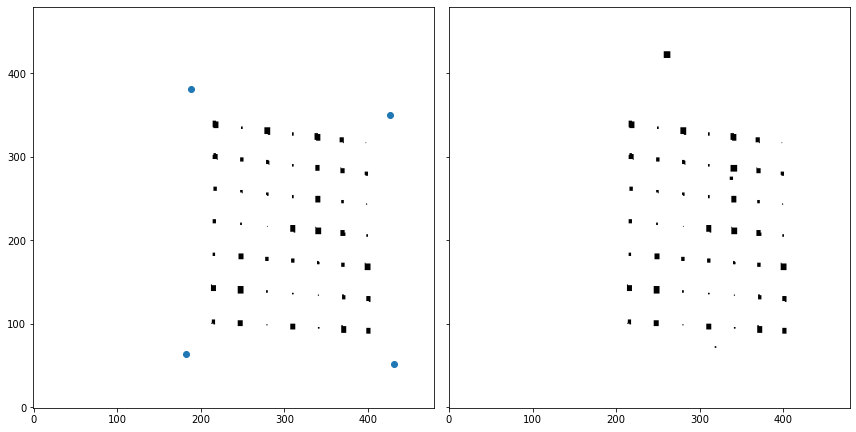

In [194]:
bd, vv = boardmask(IMGSIZE)

fig, axxes = plt.subplots(ncols=2, nrows=1, figsize=(12,6), sharex=True, sharey=True)
axxes[0].imshow(1-bd, cmap='gray', origin='lower')
axxes[0].scatter(vv.reshape((4,2)).T[0], vv.reshape((4,2)).T[1])
addpoints(bd, 4)
axxes[1].imshow(1-bd, cmap='gray', origin='lower')
fig.tight_layout()
plt.show()

In [166]:
#Clusterizing points
xsumms = np.sum(bd, axis=-1)
res = []
for y, xsumm in enumerate(xsumms):
    if xsumm == 0:
        continue
    ##TODO extend with zeros??
    s = bd[y]
    diffs = s[1:]-s[:-1]
    starts = np.where(diffs==1)[0]
    ends = np.where(diffs==-1)[0]
    for i1, i2 in zip(starts,ends):
        res.append([i1+1,i2,y])
cl = clusterize(res, closeintervals)

In [167]:
len(cl)

53

In [168]:
#Centers of clusters
xy = np.array(list(map(centerofmass, cl)))

In [169]:
xy.shape

(53, 2)

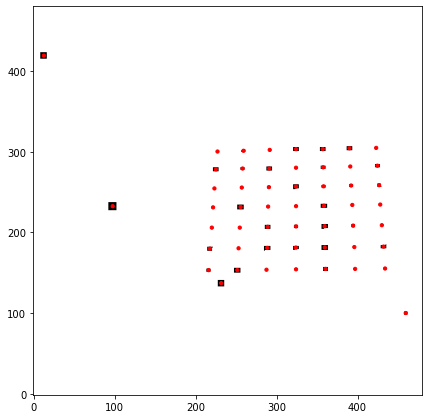

In [170]:
fig, axxes = plt.subplots(ncols=1, nrows=1, figsize=(6,6), sharex=True, sharey=True)
axxes.imshow(1-bd, cmap='gray', origin='lower')
for t in xy:
    axxes.add_patch(plt.Circle((t[0], t[1]), 2, color='r'))
fig.tight_layout()
plt.show()

In [21]:
def xcrosscorr(bd):
    cftbd = np.fft.fft2(bd)

    cross = np.real(np.fft.ifft2(np.conj(cftbd)*cftbd))
    xross = np.zeros((IMGSIZE,IMGSIZE))

    for i in range(IMGSIZE*IMGSIZE):
        x = i % IMGSIZE
        y = i // IMGSIZE
        xs = (x - HFIMGSIZE) % IMGSIZE
        ys = (y - HFIMGSIZE) % IMGSIZE
        xross[y,x] = cross[ys,xs]
    return xross

In [171]:
xross = xcrosscorr(bd)

In [172]:
xp1 = np.zeros_like(xross)
xp2 = np.zeros_like(xross)
xp1[:,HFIMGSIZE-10:HFIMGSIZE+10] = xross[:,HFIMGSIZE-10:HFIMGSIZE+10]
xp1[HFIMGSIZE-10:HFIMGSIZE+10,:] = 0
xp2[HFIMGSIZE-10:HFIMGSIZE+10,:] = xross[HFIMGSIZE-10:HFIMGSIZE+10,:]
xp2[:,HFIMGSIZE-10:HFIMGSIZE+10] = 0

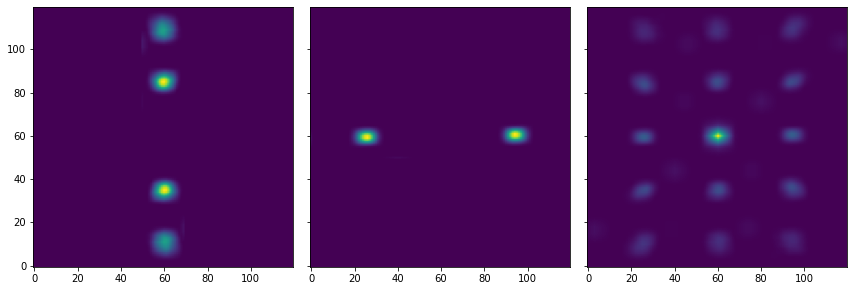

In [173]:
fig, axxes = plt.subplots(ncols=3, nrows=1, figsize=(12,4), sharex=True, sharey=True)
axxes[0].imshow(xp1[HFIMGSIZE-60:HFIMGSIZE+60,HFIMGSIZE-60:HFIMGSIZE+60], origin='lower')
axxes[1].imshow(xp2[HFIMGSIZE-60:HFIMGSIZE+60,HFIMGSIZE-60:HFIMGSIZE+60], origin='lower')
axxes[2].imshow(xross[HFIMGSIZE-60:HFIMGSIZE+60,HFIMGSIZE-60:HFIMGSIZE+60], origin='lower')
fig.tight_layout()
plt.show()

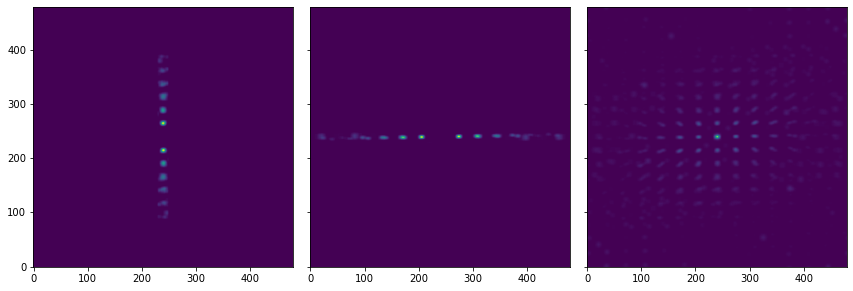

In [174]:
fig, axxes = plt.subplots(ncols=3, nrows=1, figsize=(12,4), sharex=True, sharey=True)
axxes[0].imshow(xp1, origin='lower')
axxes[1].imshow(xp2, origin='lower')
axxes[2].imshow(xross, origin='lower')
fig.tight_layout()
plt.show()

In [175]:
p1 = np.argmax(xp1)
p2 = np.argmax(xp2)
yshift = (p1 % IMGSIZE - HFIMGSIZE, p1 // IMGSIZE - HFIMGSIZE)
xshift = (p2 % IMGSIZE - HFIMGSIZE, p2 // IMGSIZE - HFIMGSIZE)
xshift, yshift

((-34, -1), (0, -25))

In [176]:
xyll = []
for t in xy:
    xyll.append(list(t))

In [177]:
def vclose(x1, x2):
    xs1 = [x1[0] + yshift[0],x1[1] + yshift[1]]
    diff1 = abs(xs1[0] - x2[0]) + abs(xs1[1] - x2[1])
    xs2 = [x2[0] + yshift[0],x2[1] + yshift[1]]
    diff2 = abs(x1[0] - xs2[0]) + abs(x1[1] - xs2[1])
    return diff1 < 10 or diff2 < 10

def hclose(x1, x2):
    xs1 = [x1[0] + xshift[0],x1[1] + xshift[1]]
    diff1 = abs(xs1[0] - x2[0]) + abs(xs1[1] - x2[1])
    xs2 = [x2[0] + xshift[0],x2[1] + xshift[1]]
    diff2 = abs(x1[0] - xs2[0]) + abs(x1[1] - xs2[1])
    return diff1 < 10 or diff2 < 10

def centerclose(x1, x2):
    return hclose(x1, x2) or vclose(x1, x2)

In [178]:
ccl = clusterize(xyll, centerclose)
len(ccl)

5

In [179]:
[len(cc) for cc in ccl]

[1, 1, 49, 1, 1]

In [180]:
ixmax = np.argmax([len(cc) for cc in ccl])

In [181]:
purecl = ccl[ixmax]

In [182]:
def vxclose(ix1, ix2):
    x1 = purecl[ix1]
    x2 = purecl[ix2]
    xs1 = [x1[0] + yshift[0],x1[1] + yshift[1]]
    diff1 = abs(xs1[0] - x2[0]) + abs(xs1[1] - x2[1])
    xs2 = [x2[0] + yshift[0],x2[1] + yshift[1]]
    diff2 = abs(x1[0] - xs2[0]) + abs(x1[1] - xs2[1])
    return diff1 < 10 or diff2 < 10

def hxclose(ix1, ix2):
    x1 = purecl[ix1]
    x2 = purecl[ix2]
    xs1 = [x1[0] + xshift[0],x1[1] + xshift[1]]
    diff1 = abs(xs1[0] - x2[0]) + abs(xs1[1] - x2[1])
    xs2 = [x2[0] + xshift[0],x2[1] + xshift[1]]
    diff2 = abs(x1[0] - xs2[0]) + abs(x1[1] - xs2[1])
    return diff1 < 10 or diff2 < 10


In [183]:
len(purecl)

49

In [184]:
vvx = clusterize(np.arange(49), vxclose)
hhx = clusterize(np.arange(49), hxclose)

In [185]:
vvx

[[3, 4, 6, 33, 35, 36, 0],
 [9, 7, 11, 29, 32, 38, 1],
 [5, 48, 8, 31, 34, 37, 2],
 [12, 26, 13, 28, 30, 39, 10],
 [15, 23, 25, 27, 41, 40, 14],
 [18, 21, 24, 44, 43, 42, 16],
 [19, 20, 22, 46, 45, 47, 17]]

In [186]:
hhx

[[48, 1, 13, 15, 16, 17, 0],
 [3, 9, 12, 14, 18, 19, 2],
 [5, 7, 10, 23, 21, 20, 4],
 [8, 11, 26, 25, 24, 22, 6],
 [28, 44, 29, 31, 33, 46, 27],
 [32, 41, 34, 35, 43, 45, 30],
 [37, 38, 39, 40, 42, 47, 36]]

In [187]:
[len(vv) for vv in vvx], [len(hh) for hh in hhx]

([7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7])

In [188]:
ss = np.array([[purecl[i] for i in vv] for vv in vvx])
tt = np.array([[purecl[i] for i in hh] for hh in hhx])

In [189]:
s = np.mean(ss, axis=1)
t = np.mean(tt, axis=1)

In [190]:
sortx = np.argsort(s[:,0])
sorty = np.argsort(t[:,1])

In [191]:
sortx

array([0, 2, 1, 3, 4, 5, 6])

In [192]:
sorty

array([0, 1, 2, 3, 4, 5, 6])

In [137]:
cls = ['red','blue','green','yellow','cyan','pink','magenta']

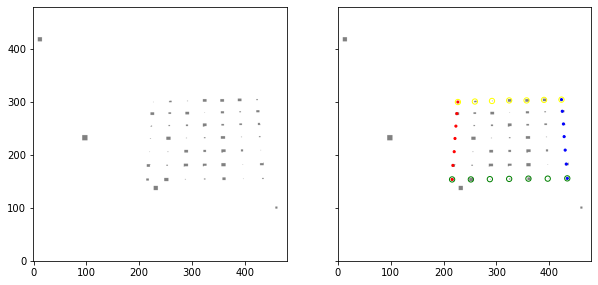

In [193]:
fig, axxes = plt.subplots(ncols=2, nrows=1, figsize=(10,5), sharex=True, sharey=True)
axxes[0].imshow(1-bd, cmap='gray', origin='lower', alpha=0.5)
axxes[1].imshow(1-bd, cmap='gray', origin='lower', alpha=0.5)
for i, v in enumerate(purecl):
    if (i in vvx[0]):
        axxes[1].add_patch(plt.Circle((v[0], v[1]), 2, color=cls[0]))
    if (i in vvx[6]):
        axxes[1].add_patch(plt.Circle((v[0], v[1]), 2, color=cls[1]))
    if (i in hhx[0]):
        axxes[1].add_patch(plt.Circle((v[0], v[1]), 5, color=cls[2], fill=False))
    if (i in hhx[6]):
        axxes[1].add_patch(plt.Circle((v[0], v[1]), 5, color=cls[3], fill=False))
plt.show()